In [23]:
import gc
import torch
from tqdm import tqdm

from predict import compute_gradient_direction
from training import kp_loss
from utils import imshow, save_model,create_circular_mask
from config import device, args
from training.tensor_augmetation import random_augmentation, shifted_batch_tensor


In [24]:
import time
#create function to calcule time of code
def time_code(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return int(hours), int(minutes), seconds

### Trecho responsavel pelo treinamento epoca a epoca.
 - Problemas encontrados:
    - [ ] Garantir que os principais pontos detectados apareça na mesma posição

    - [ ] Fazer o mapeamento de pontos em outra transformação t(f(x)) == f(t(x))
    
    - [X] Ordenar os pontos de acordo com a intensidade no mapa de ativação da detecção

In [25]:
from torchvision.transforms import transforms, InterpolationMode
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

torch.manual_seed(42)
torch.cuda.manual_seed(42)

MODEL_PATH = "./data/models/model_{}.pt".format("flowers_ssim_teste")
print(MODEL_PATH)
args.img_size = 170
args.dim_first = 2
args.dim_second = 3
args.dim_third = 4
args.batch_size = 11
args.is_loss_ssim = True


transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)

iterator=iter(trainloader)
batch = next(iterator)
img_batch, labels =batch

./data/models/model_flowers_ssim_teste.pt


In [26]:

def train_one_epoch(model, loader, optimizer, criterion_d ,criterion_o, epoch, is_show=True):
    model.train()
    running_loss = 0.
    qtd_batch = len(loader)
    t = tqdm(loader, desc="Train Epoch:{} ".format(epoch))
    for batch_idx, (batch_image, labels) in enumerate(t):
        loss1 = 0
        loss2 = 0

        start = time.time()

        batch_image = batch_image.to(device)
        _kp1, _orie1 = model(batch_image)


        _B, _C, _W, _H = batch_image.shape
        SIZE_BORDER = args.border_size
        batch_mask = torch.zeros(_B, 1, _W, _H).to(device)
        batch_mask[:, :, SIZE_BORDER:_W - SIZE_BORDER, SIZE_BORDER:_H - SIZE_BORDER] = 1

        print(_kp1.shape, _orie1.shape, batch_mask.shape, img_batch.shape)
        batch_image_pos_trans, feature_kp_anchor_trans, features_ori_anchor_trans,mask_trans = random_augmentation(
            batch_image,
            _kp1, _orie1,batch_mask)

        _kp2_pos, _orie2_pos = model(batch_image_pos_trans)
        batch_image_neg_trans, _kp2_neg, _orie2_neg = shifted_batch_tensor(batch_image_pos_trans, _kp2_pos,
                                                                           _orie2_pos)  # faz o shift com o comando roll(x,1,0)
        end = time.time()
        hours, minutes, seconds = time_code(start, end)
        # print("Tempo de execução predict : {:0>2}:{:0>2}:{:05.2f}".format(hours,minutes,seconds))
        # start = end

        if is_show and batch_idx % 25 == 0:
            temp = torch.cat([batch_image_pos_trans[3], batch_image_pos_trans[3] * mask_trans[3],
                              batch_image_neg_trans[3] * mask_trans[3]], dim=-1)
            imshow(temp)
            temp = torch.cat([feature_kp_anchor_trans[3] * mask_trans[3], _kp2_pos[3] * mask_trans[3],
                              _kp2_neg[3] * mask_trans[3]], dim=-1)
            imshow(temp)
            fo2 = features_ori_anchor_trans*mask_trans
            fo2 = compute_gradient_direction(fo2)

            op2 = _orie2_pos*mask_trans
            op2 = compute_gradient_direction(op2)

            on2 = _orie2_neg*mask_trans
            on2 = compute_gradient_direction(on2)
            temp = torch.cat([fo2[3],op2[3],on2[3]], dim=-1)[None]
            imshow(temp)

        loss1 = criterion_d(feature_kp_anchor_trans*mask_trans, _kp2_pos*mask_trans, _kp2_neg*mask_trans)

        if isinstance(criterion_o, kp_loss):
            loss2 = criterion_o(features_ori_anchor_trans * mask_trans, _orie2_pos * mask_trans)
        else:
            loss2 = criterion_o(features_ori_anchor_trans * mask_trans, _orie2_pos * mask_trans, _orie2_neg * mask_trans)

        loss = loss1 + loss2


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        try:
            running_loss += (loss.item()/qtd_batch)
        except AttributeError:
            print('AttributeError ', type(loss), loss)

        t.set_description("Train Epoch:{} Loss: {:.5f}".format(epoch, running_loss))


        del batch_image
        del batch_image_neg_trans
        del _kp1, _kp2_pos, _kp2_neg, _orie1, _orie2_pos, _orie2_neg
        gc.collect()
        torch.cuda.empty_cache()

    model.eval()
    # print('Train Epoch: {} \tLoss: {:.15f}'.format(
    #     epoch, running_loss))
    return running_loss


In [27]:
# from training import KeyEqGroup
# from utils import load_model,save_model
# from training import KeyEqGroup,kp_loss as simple_loss,triplet_loss as loss_function

# model = KeyEqGroup(args).to(device)
# i_epoch = 0
# loss = 0
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
# scheduler = ExponentialLR(optimizer, gamma=0.75)

# try:
#     model, optimizer, i_epoch, loss = load_model(model, optimizer, path=MODEL_PATH)
#     print("Já foi treinado")
#     print("epoca {} loss {}".format(i_epoch, loss))
# except:
#     print("Não foi treinado ainda")


# for epoch in range(i_epoch, args.epochs):
#     criterion_d = loss_function(is_ssim=args.is_loss_ssim, margim=args.margin_loss)
#     # criterion_o = loss_function(is_ssim=args.is_loss_ssim, margim=args.margin_loss)
#     criterion_o = simple_loss()
#     running_loss = train_one_epoch(model, trainloader, optimizer=optimizer, criterion_d=criterion_d,criterion_o=criterion_o,epoch=epoch, is_show=True)
    
#     valid_loss =running_loss
#     # valid_loss = test(model, testloader, criterion=criterion_d,epoch=epoch)
#     if (epoch % 5 == 0) and (epoch != 0):
#         scheduler.step()
#     print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])

#     if valid_loss <= 0.0:
#         break

### Detecção de pontos maximos em imagens
- [X] A entrada de dados se dar por meio de tensores
- [X] Detectar pontos com base em um tamanho de janela e trheasold
- [ ] Capacidade de extrair os pontos mais importantes
- [ ] Avaliar a detecção de pontos com base em tranformações distintas


In [28]:
import torch
import torch.nn.functional as F
import numpy as np

class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        """
        Detects the maximum points in a batch of images.

        Args:
        - images: Tensor with dimensions [b, channel, height, width] containing the images.
        - size: Size of the maximum filter.
        - threshold: Threshold to consider a point as maximum.

        Returns:
        - max_coords_values: Tensor containing the coordinates of the maximum points along with the corresponding scalar values.
        - max_map: Tensor containing the resulting maximum map.
        """
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()
        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]

        

        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)
        max_coords_values = max_coords_values[:, [0,1,3,2,4]]# trocando x e y de ordem antes de concatenar
        return max_coords_values, max_map.squeeze().numpy()

    def filter_coordinates(self, tensor, image_index, channel_index):
        """
        Filters coordinates in a tensor based on the image and channel indices.

        Args:
        - tensor: Tensor with dimensions [b, channel, x, y] containing the data.
        - image_index: Image index to filter the coordinates.
        - channel_index: Channel index to filter the coordinates.

        Returns:
        - filtered_coords: Tensor containing the filtered coordinates.
        """
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)
        return filtered_coords

    def sort_matrix_by_last_element(self, matrix):
        """
        Sorts the rows of a matrix based on the last element of each row.

        Args:
        - matrix: NumPy array representing the matrix.

        Returns:
        - sorted_matrix: NumPy array with sorted rows in descending order based on the last element.
        """
        indices = np.argsort(-matrix[:, -1])  # Sort based on the last column
        sorted_matrix = matrix[indices]
        return sorted_matrix
    


In [29]:
import matplotlib.pyplot as plt
#function plot imagem and coords
def plot_image_and_coords(image, coords):
    plt.imshow(image)
    for i, (x,y) in enumerate(coords):
        plt.plot(x, y, '.',markerfacecolor='none', markeredgecolor='r',
                markersize=10, markeredgewidth=1)
        plt.annotate(str(i), (x, y), color='r',xytext=(3, 3), textcoords='offset points', fontsize=12)
    plt.show()
    
def detector_sumary(batch,nsm_size=5,threshold=1e-3):
    detector = MaxPointDetector()
    NSM_SIZE = nsm_size # tem que ser impar
    max_coords_values, max_map = detector.detect_max_points(batch, size=NSM_SIZE, threshold=threshold)
    valores_filtrados = detector.filter_coordinates(max_coords_values, image_index=0, channel_index=0)
    valores_ordenados = detector.sort_matrix_by_last_element(valores_filtrados)
    points = valores_ordenados[:40, 0:2][None]
    print('pontos detectados do batch ',max_coords_values.shape,' pontos de uma imagem',points.shape,max_map.shape)
    return points,max_map

#### Plotar os pontos detectados na imagem e mapa de ativação

pontos detectados do batch  torch.Size([694, 5])  pontos de uma imagem torch.Size([1, 40, 2]) (170, 170)


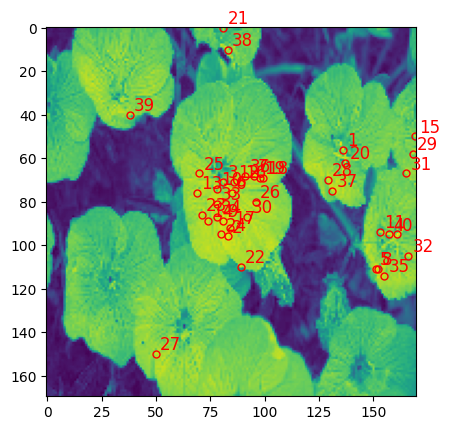

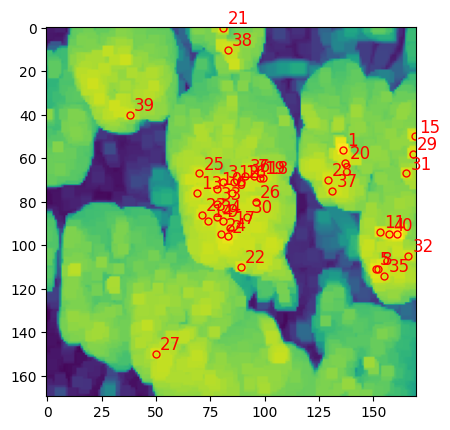

In [30]:
input_batch = img_batch[:1,:1,:,:]


points,max_map = detector_sumary(input_batch)

plot_image_and_coords(input_batch[0,0], points[0])
plot_image_and_coords(max_map, points[0])

#### Avaliar o detector sob varias transformações

Sequencia de exibições :
- t(f(x)) - mapa de ativacao
- f(t(x)) - imagem
- f(t(x)) - mapa de ativacao

torch.Size([1, 1, 170, 170]) torch.Size([170, 170]) torch.Size([1, 40, 2])
t(f(x)) - Mapa de ativação transformado


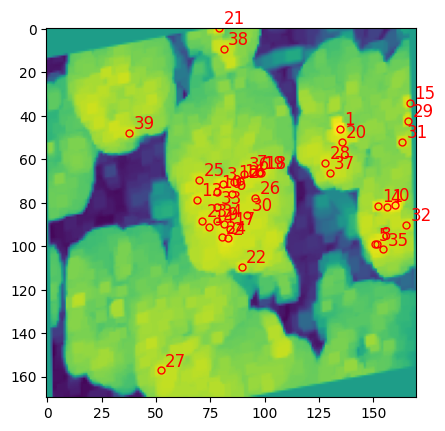

pontos detectados do batch  torch.Size([471, 5])  pontos de uma imagem torch.Size([1, 40, 2]) (170, 170)
f(t(x)) - Mapa de ativação transformado


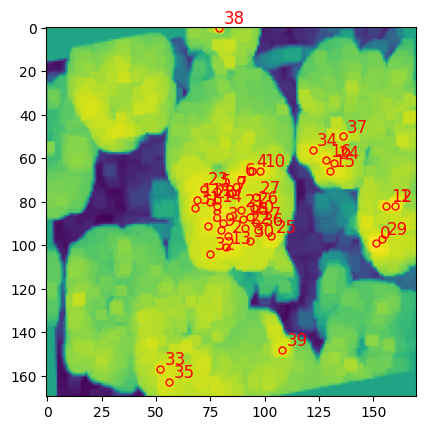

f(t(x)) - Imagem


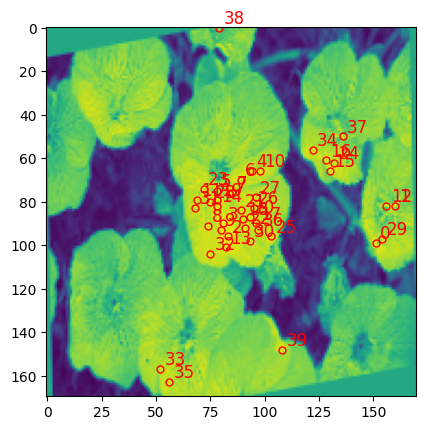

In [31]:
import kornia
import kornia.augmentation as K


aug_list = K.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=[-45, 45],shear=10,align_corners=True, p=1.,same_on_batch=True,keepdim=True),
    data_keys=["input","input","keypoints"]
)


_max_map= torch.tensor(max_map,dtype=torch.float32)
print(input_batch.shape,_max_map.shape,points.shape)

input_trans,max_map_trans,points_trans = aug_list(input_batch,_max_map, points)
print("t(f(x)) - Mapa de ativação transformado")
plot_image_and_coords(max_map_trans, points_trans[0])

points2,max_maps2 = detector_sumary(input_trans)

print("f(t(x)) - Mapa de ativação transformado")
plot_image_and_coords(max_maps2, points2[0])
print("f(t(x)) - Imagem")
plot_image_and_coords(input_trans[0,0], points2[0])


In [32]:
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


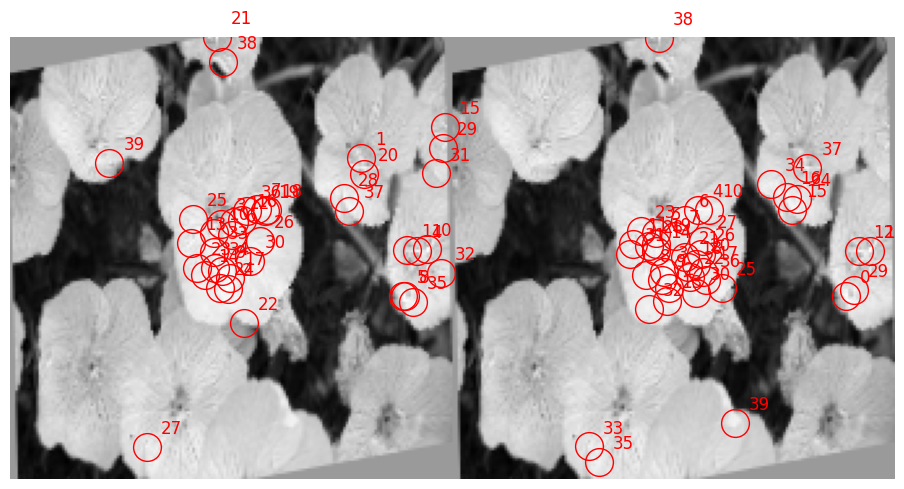

In [33]:
matching_results = []#[(i, i) for i in range(10)]
plot_matches_keypoints(input_trans[0,0], points_trans[0],input_trans[0,0],points2[0], matching_results)